In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
import plotly.express as px
import re
import glob
import lightkurve as lk
import astropy.units as u

%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams['axes.formatter.useoffset'] = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Wasp 103 investigation

### Assemble dataset

Are there TESS lightcurves?

In [5]:
lk.search_lightcurve(target="Wasp-103")

No data found for target "Wasp-103".
No data found for target "Wasp-103".


SearchResult containing 0 data products.

In [6]:
# start with exoclock's database
exoclock_data = pd.read_csv("./data/ExoClock/all_mid_time_data.txt", sep="\s+").sort_values("transit_time")
exoclock_data = exoclock_data[exoclock_data.planet == "WASP-103b"].reset_index(drop=True).drop(columns=["planet", "ID"])  # includes TESS 2019
exoclock_data.source = exoclock_data.source.map({"literature": "ExoClock_Literature", "exoclock": "ExoClock_Original", "space": "ExoClock_TESS"})
exoclock_data

,transit_time,error,source
0,2456459.59957,0.00075,ExoClock_Literature
1,2456767.80578,0.00017,ExoClock_Literature
2,2456779.83870,0.00022,ExoClock_Literature
3,2456817.78572,0.00027,ExoClock_Literature
4,2456831.66843,0.00039,ExoClock_Literature
5,2456832.59401,0.00024,ExoClock_Literature
6,2456836.29643,0.00006,ExoClock_Literature
7,2456844.62633,0.00019,ExoClock_Literature
8,2456844.62641,0.00019,ExoClock_Literature
9,2456844.62642,0.00034,ExoClock_Literature


In [7]:
etd_data = pd.read_csv("./data/ETD/ORIGINALS/ETD_WASP-103_og.txt", sep="\t", names=["index", "epoch", "transit_time", "error", "data_quality", "observer"]).loc[:, ["transit_time", "error"]].sort_values("transit_time")
etd_data["source"] = "ETD"
etd_data

,transit_time,error,source
0,2456771.50648,0.00100,ETD
1,2456796.49490,0.00284,ETD
2,2456809.45037,0.00173,ETD
3,2456821.48851,0.00159,ETD
4,2456846.47604,0.00138,ETD
5,2456895.53393,0.00054,ETD
6,2457117.66079,0.00183,ETD
7,2457118.57880,0.00226,ETD
8,2457180.59602,0.00171,ETD
9,2457181.52533,0.00126,ETD


In [8]:
en_masse_data = pd.read_csv("./data/Transit-Timing-En-Masse/table.csv")
en_masse_data = en_masse_data[en_masse_data.planet == "WASP-103"].loc[:, ["transit_time", "error"]]
en_masse_data["source"] = "Transit_Timing_En_Masse"
en_masse_data

,transit_time,error,source
7085,2456459.59968,0.00095,Transit_Timing_En_Masse
7086,2456472.55818,0.00096,Transit_Timing_En_Masse
7087,2456485.51480,0.00088,Transit_Timing_En_Masse
7088,2456497.54630,0.00076,Transit_Timing_En_Masse
7089,2456509.57806,0.00070,Transit_Timing_En_Masse
7090,2456767.80583,0.00028,Transit_Timing_En_Masse
7091,2456779.83874,0.00040,Transit_Timing_En_Masse
7092,2456817.78569,0.00037,Transit_Timing_En_Masse
7093,2456819.63655,0.00053,Transit_Timing_En_Masse
7094,2456831.66832,0.00047,Transit_Timing_En_Masse


In [9]:
HOUR_IN_DAYS = 1 / 24
HOUR_IN_DAYS

0.041666666666666664

In [10]:
PERIOD = 0.925542

In [11]:
df = pd.concat([exoclock_data, etd_data, en_masse_data]).sort_values("transit_time").drop_duplicates(["transit_time"]).reset_index(drop=True)
df["epoch"] = ((df.transit_time - df.transit_time[0]) / PERIOD).round()
df[df.duplicated(["epoch"])]

,transit_time,error,source,epoch
1,2456459.59968,0.00095,Transit_Timing_En_Masse,0.00000
7,2456767.80583,0.00028,Transit_Timing_En_Masse,333.00000
10,2456779.83874,0.00040,Transit_Timing_En_Masse,346.00000
14,2456817.78572,0.00027,ExoClock_Literature,387.00000
18,2456831.66843,0.00039,ExoClock_Literature,402.00000
20,2456832.59401,0.00024,ExoClock_Literature,403.00000
23,2456844.62633,0.00019,ExoClock_Literature,416.00000
24,2456844.62641,0.00019,ExoClock_Literature,416.00000
25,2456844.62642,0.00034,ExoClock_Literature,416.00000
26,2456844.62647,0.00023,ExoClock_Literature,416.00000


In [12]:
df = df.drop_duplicates(["epoch"]).reset_index(drop=True)  # do we need to do this or can we include duplicates fitted by different pipelines?
df

,transit_time,error,source,epoch
0,2456459.59957,0.00075,ExoClock_Literature,0.00000
1,2456472.55818,0.00096,Transit_Timing_En_Masse,14.00000
2,2456485.51480,0.00088,Transit_Timing_En_Masse,28.00000
3,2456497.54630,0.00076,Transit_Timing_En_Masse,41.00000
4,2456509.57806,0.00070,Transit_Timing_En_Masse,54.00000
5,2456767.80578,0.00017,ExoClock_Literature,333.00000
6,2456771.50648,0.00100,ETD,337.00000
7,2456779.83870,0.00022,ExoClock_Literature,346.00000
8,2456796.49490,0.00284,ETD,364.00000
9,2456809.45037,0.00173,ETD,378.00000


How much more data do we now have?

In [13]:
len(etd_data), len(df)

(49, 82)

What do the transit times look like when plotted:

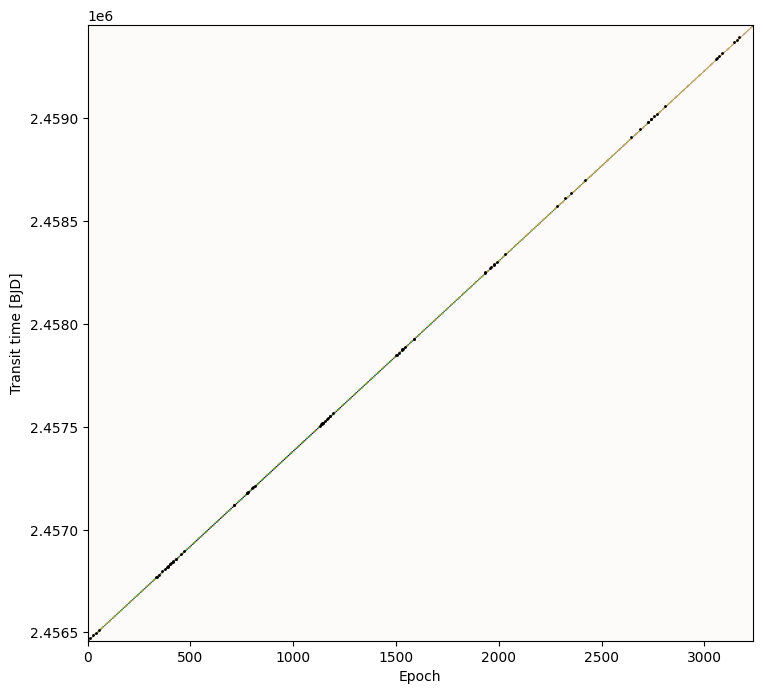

In [14]:
kernel = sp.stats.gaussian_kde(np.vstack([df.epoch, df.transit_time]))

xmin = df.epoch.min()
xmax = df.epoch.max()
ymin = df.transit_time.min()
ymax = df.transit_time.max()
X, Y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]

positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(df.epoch, df.transit_time, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.xlabel("Epoch")
plt.ylabel("Transit time [BJD]")
plt.show()

### Fitting

Non-parametric outlier detection:

In [15]:
from code.outlier_detection import non_parametric

survivors, outliers = non_parametric.non_parametric_without_error(df, threshold=0.1)
df["is_outlier"] = df.index.isin(outliers.index)
outliers

,transit_time,error,source,epoch,residuals
9,2456809.45037,0.00173,ETD,378.00000,-0.00463
21,2456895.53393,0.00054,ETD,471.00000,0.00319
23,2457118.57880,0.00226,ETD,712.00000,-0.00845
32,2457504.53537,0.00202,ETD,1129.00000,-0.00442
59,2458301.43845,0.00121,ETD,1990.00000,0.00385
64,2458699.43551,0.02647,ETD,2420.00000,0.01627


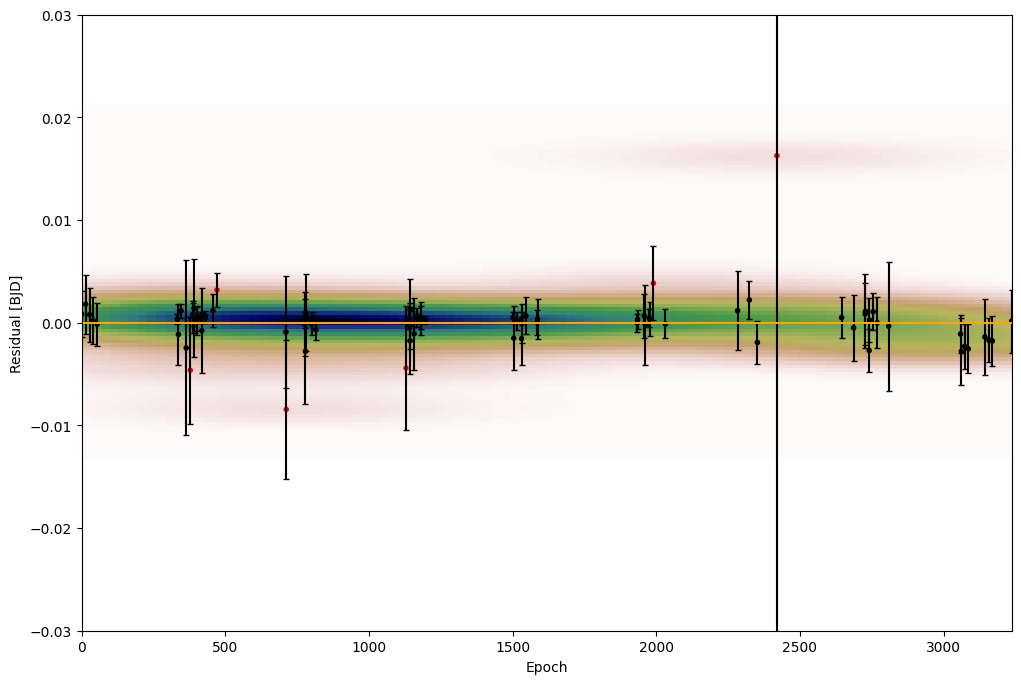

In [16]:
def colors(v):
    if v:
        return "red"
    return "black"
    
X = np.vstack(
    [
        np.power(df.epoch, 0.0),
        np.power(df.epoch, 1.0)
        # do not use a decay term
    ]
).T
y = np.atleast_2d(df.transit_time.values).T
beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
y_hat = (X @ beta).flatten()
residuals = (y.flatten() - y_hat.flatten())

kernel = sp.stats.gaussian_kde(np.vstack([df.epoch, residuals]))

xmin = df.epoch.min()
xmax = df.epoch.max()
ymin = residuals.min() - 0.005
ymax = residuals.max() + 0.005
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax], aspect="auto")
plt.errorbar(df.epoch, residuals, yerr=3*df.error, fmt=".k", markersize=0, capsize=2)
plt.scatter(df.epoch, residuals, c=df.is_outlier.map(colors), marker=".")
plt.axhline(0, color="orange")
plt.ylabel("Residual [BJD]")
plt.xlabel("Epoch")
plt.ylim((-0.03, 0.03))
plt.show()

In [17]:
from code.fitting import analytical

df = survivors.copy()
beta, t_sigma, posterior_errors, k, t_dof = analytical.bayesian_mvn_regression_fit(df, K0=np.diag([1e-12, 1e-12, 1e-12]))
beta, t_sigma

E[dP/dE] = -0.03428492370002214 ms/epoch SD[dP/dE] = 0.0149186794832505 Prob(dP/dE < 0) = 0.9887459702349332


(array([[ 2.45645960e+06],
        [ 9.25545929e-01],
        [-3.96816247e-10]]),
 array([[ 1.68832462e-08, -2.61713210e-11,  1.66271970e-14],
        [-2.61713210e-11,  5.09222579e-14, -3.62977365e-17],
        [ 1.66271970e-14, -3.62977365e-17,  2.90404820e-20]]))

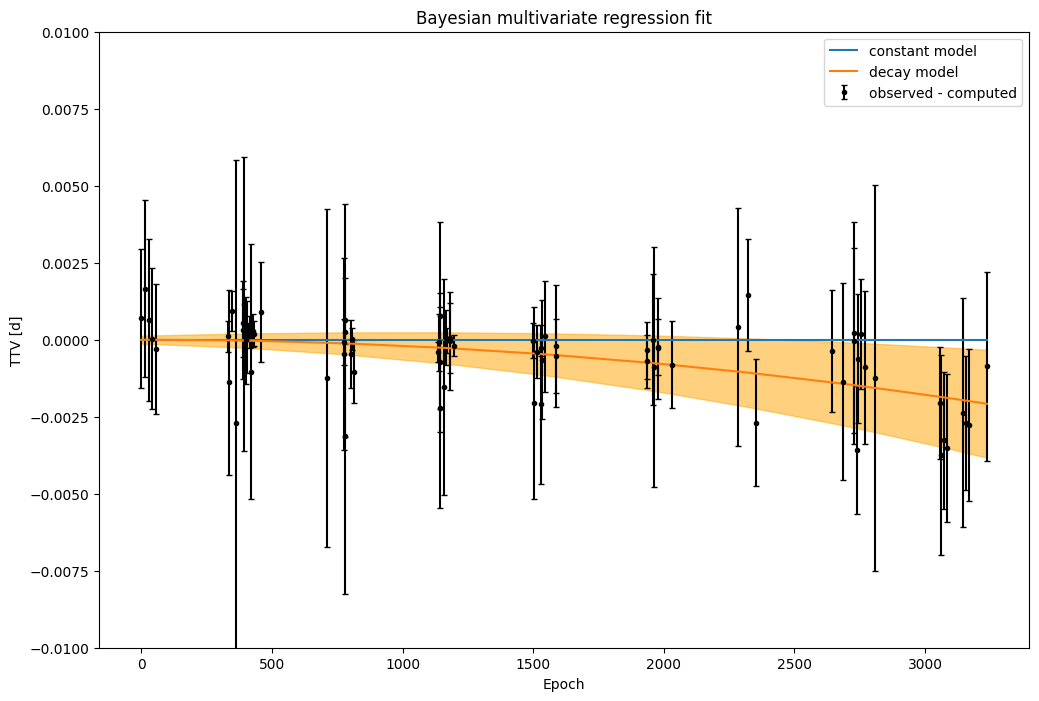

In [30]:
X = np.vstack(
    [
        np.power(df.epoch, 0.0),
        np.power(df.epoch, 1.0),
        0.5 * np.power(df.epoch, 2.0),
    ]
).T
y = np.atleast_2d(df.transit_time.values).T
y_error = 3*np.atleast_2d(df.error.values).T

fit_error = 1*np.atleast_2d(np.sqrt(np.diag(t_sigma))).T
upper_fit = X@(beta+fit_error)
lower_fit = X@(beta-fit_error)

const_beta = np.copy(beta)
const_beta[2, 0] = 0
const_y = X@const_beta
decay_y = X@beta
occ = (y - const_y).flatten()
plt.errorbar(df.epoch, occ, yerr=3*df.error, fmt=".k", capsize=2, label="observed - computed")

deviation = decay_y - const_y
deviation_upper = (upper_fit - const_y).flatten()
deviation_lower = (lower_fit - const_y).flatten()

plt.plot(df.epoch, np.full(occ.shape, 0), label="constant model")
plt.plot(df.epoch, deviation, label="decay model")
plt.ylim([-0.05, 0.05])
plt.fill_between(df.epoch, deviation_upper, deviation_lower, color='orange', alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("TTV [d]")
plt.title("Bayesian multivariate regression fit")
plt.legend()
plt.ylim((-0.01, 0.01))
plt.show()

In [31]:
# ^ above plot but the shaded region shows only the error in transit time due to dP/dE bounds

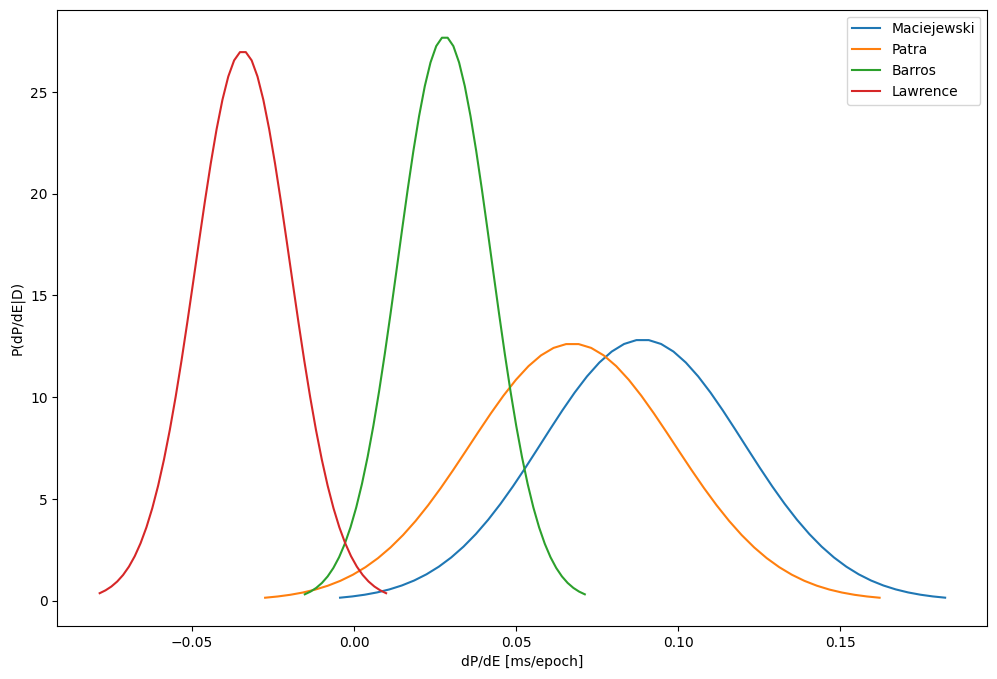

In [19]:
# Maciejewski: (1.03±0.36)×10−9 days/epoch
mu = 1.03e-9 * (24 * 60 * 60 * 1000)
sd = 0.36e-9 * (24 * 60 * 60 * 1000)
x = np.linspace(mu - 3*sd, mu + 3*sd)
plt.plot(x, sp.stats.norm.pdf(x, mu, sd), label="Maciejewski")

# Patra: dP/dt = (8.42 +- 3.95)x10-10
mu = 8.42e-10 * PERIOD * (24 * 60 * 60 * 1000)
sd = 3.95e-10 * PERIOD * (24 * 60 * 60 * 1000)
x = np.linspace(mu - 3*sd, mu + 3*sd)
plt.plot(x, sp.stats.norm.pdf(x, mu, sd), label="Patra")

# Barros: dP/dt = 3.5 ± 1.8 × 10−10 days/day
mu = 3.5e-10 * PERIOD * (24 * 60 * 60 * 1000)
sd = 1.8e-10 * PERIOD * (24 * 60 * 60 * 1000)
x = np.linspace(mu - 3*sd, mu + 3*sd)
plt.plot(x, sp.stats.norm.pdf(x, mu, sd), label="Barros")

# Lawrence's fit
mu = beta[2] * (24 * 60 * 60 * 1000)  # ms/epoch
t_sd = np.sqrt(t_sigma[2, 2]) * 24 * 60 * 60 * 1000
x = np.linspace(mu - 3*t_sd, mu + 3*t_sd)
plt.plot(x, sp.stats.t.pdf(x, t_dof, mu, t_sd), label="Lawrence")

plt.xlabel("dP/dE [ms/epoch]")
plt.ylabel("P(dP/dE|D)")
plt.legend()
plt.show()

Compare BIC and chi squared of fitted models

In [20]:
len(df)

76

In [21]:
from code import stats

residuals = stats.compute_residuals(df, beta)
normalised_residuals = residuals / posterior_errors
X2 = np.power(normalised_residuals, 2.0).sum()
X2 / (len(df)+3)

2.427719020946781

In [22]:
stats.bic(df, beta, k)

-456.54041006324053

Lower BIC than Barros, higher $X^2_v$ than Maciejewski.

### Theory:

In [23]:
earth_radius = 6.378e6  # m
earth_mass = 5.972e24  # kg
solar_radius = 6.957e8 # m
solar_mass = 1.989e30  # kg

In [24]:
# values from Gillon et al 2014 where possible, or Addison et al 2016
e = 0.0
Rs = 1.436 * solar_radius # stellar radius
Rp = 17.127 * earth_radius
Ms = 1.220 * solar_mass
Mp = 473.547 * earth_mass
a = 0.01985 * sp.constants.au # semi major axis
P = 0.925542

Qs = 10 ** 5.5
Qp = 10 ** 6.5

stellar_tide_da_dt = \
    -(9/2 * ((sp.constants.G / Ms) ** 0.5) * ((Rs ** 5 * Mp) / Qs) * (1 + (57/4 * e ** 2))) * (a ** -5.5)

planetary_tide_da_dt = \
    -(63/2 * ((sp.constants.G * Ms ** 3) ** 0.5) * (Rp ** 5 / (Qp * Mp)) * e ** 2) * (a ** -5.5)

total_da_dt = stellar_tide_da_dt + planetary_tide_da_dt

# using Kepler's third law to convert to dP/dt in ms/year
dP_dt = 3 * sp.constants.pi * np.sqrt(a  / (sp.constants.G * Ms)) * total_da_dt * 365 * 24 * 60 * 60 * 1000

# then converting to ms/epoch
dP_dE = dP_dt * (P / 365)
dP_dE

-0.0538684389641536

In [25]:
stellar_tide_da_dt, planetary_tide_da_dt

(-1.6692085339548778e-05, -0.0)

In [26]:
observation = (beta[2] * 24 * 60 * 60 * 1000).item()
observation

-0.03428492370002214

How does decay rate vary with Q*?

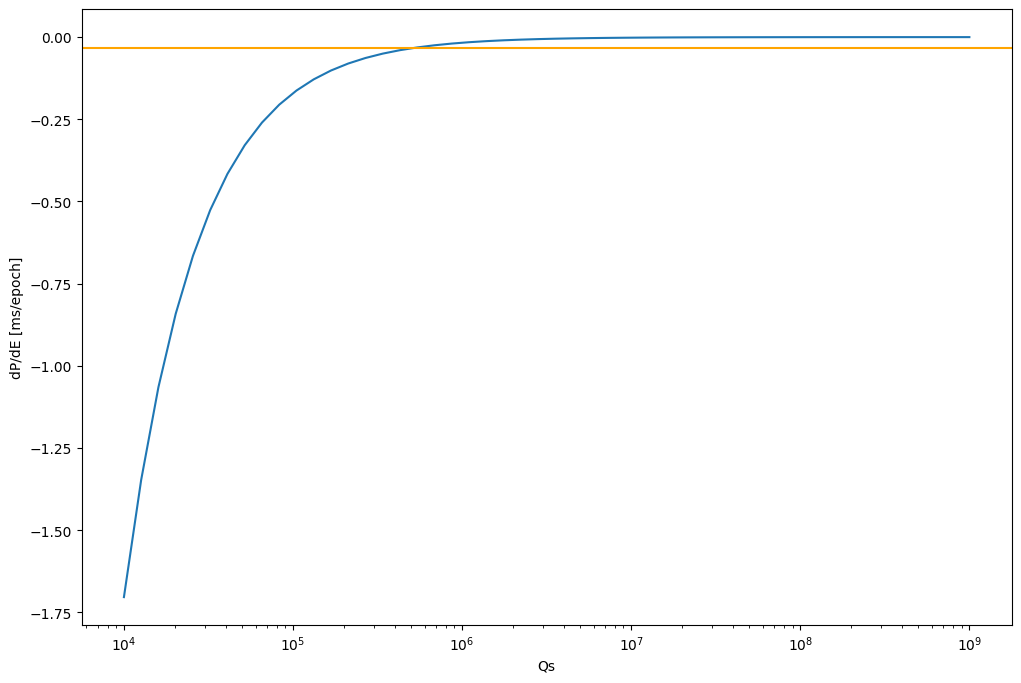

In [27]:
Qs = np.logspace(4, 9)

stellar_tide_da_dt = \
    -(9/2 * ((sp.constants.G / Ms) ** 0.5) * ((Rs ** 5 * Mp) / Qs) * (1 + (57/4 * e ** 2))) * (a ** -5.5)
dP_dt = 3 * sp.constants.pi * np.sqrt(a  / (sp.constants.G * Ms)) * stellar_tide_da_dt * 365 * 24 * 60 * 60 * 1000
dP_dE = dP_dt * (P / 365)

pd.Series(dP_dE, index=Qs).plot(xlabel="Qs", ylabel="dP/dE [ms/epoch]", logx=True, logy=False)
plt.axhline(observation, color="orange")

How does decay rate vary with eccentricity?

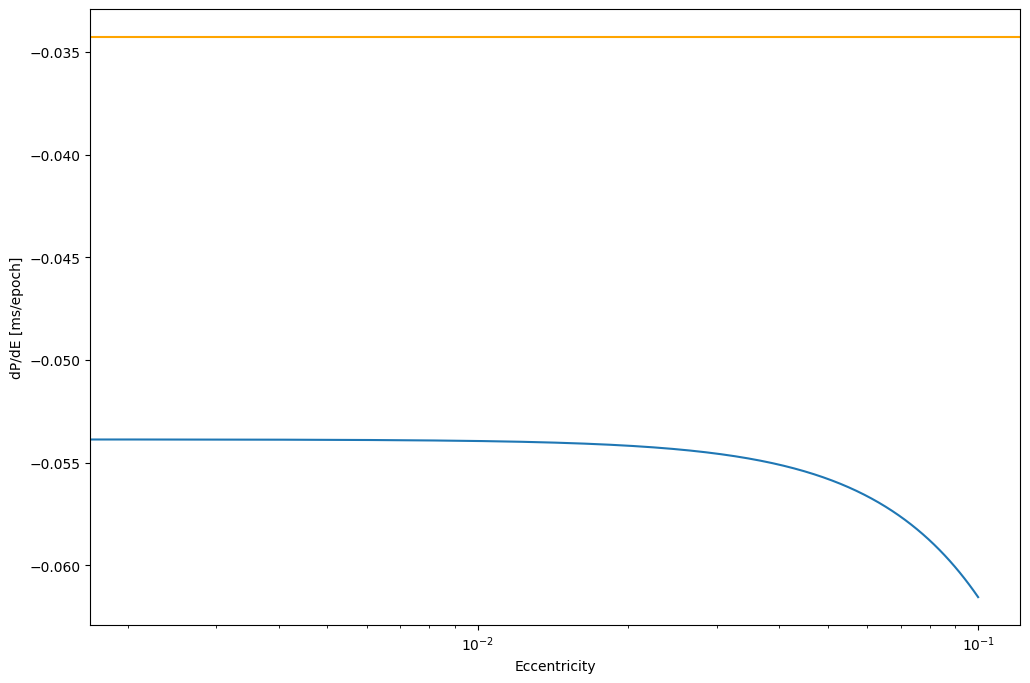

In [28]:
Qs = 10 ** 5.5
e = np.linspace(0, 0.1)

stellar_tide_da_dt = \
    -(9/2 * ((sp.constants.G / Ms) ** 0.5) * ((Rs ** 5 * Mp) / Qs) * (1 + (57/4 * e ** 2))) * (a ** -5.5)
dP_dt = 3 * sp.constants.pi * np.sqrt(a  / (sp.constants.G * Ms)) * stellar_tide_da_dt * 365 * 24 * 60 * 60 * 1000
dP_dE = dP_dt * (P / 365)

pd.Series(dP_dE, index=e).plot(xlabel="Eccentricity", ylabel="dP/dE [ms/epoch]", logx=True, logy=False)
plt.axhline(observation, color="orange")